In [124]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

In [125]:
%matplotlib notebook
plt.ion()

In [257]:
class Station:
    id_ = 0
    def __init__ (self  , name , number_of_tracks ):
        '''
        @parameters 
        number_of_tracks : number of parallel tracks in the station
        name : name of the station

        TODO
        Assign more attribute to train tracks e.g. max_speed, unidirectional or bidirectional
        '''
        self.__class__.id_ += 1
        self.n_parallel_tracks = number_of_tracks
        self.name = name
        self.id = self.__class__.id_
        
        #to indicate weather the track at the station is free or not: true means free
        self.free = [True for _ in range(number_of_tracks)]
        self.free_tracks = number_of_tracks
        
    def lock_line (self):
        '''
        This method locks the tracks that is free and return the track index 
        If no track is free then it returns -1
        '''
        
        for i in range(self.n_parallel_tracks):
            if (self.free[i]):
                self.free[i] = False
                self.free_tracks -= 1
                return i
        
        return -1
        
    def free_line (self , index):
        '''
        Frees the tracks with index
        '''
        
        if (self.free[index] == False):
            self.free[index] = True
            self.free_tracks += 1
            
            
    def print_details(self):
        '''
        Print the details of the station
        '''
        print('*' * 50)
        print("Station {}".format(self.id))
        print("Station name : {}".format(self.name))
        print("Number of tracks : {}".format(self.n_parallel_tracks))
        print("Number of free tracks : {}".format(self.free_tracks))
        print("Track status")
        for i in range(self.n_parallel_tracks):
            print("Track {} : {}".format(i , "free" if self.free[i] else "not free") )
        print('*' * 50) 

In [258]:
class Track:
    id_ = 0
    def __init__ (self , total_parallel_tracks , length_of_tracks):
        '''
        Tracks in between the stations
        Note : In this model, we are not using multigraph to represent multiple tracks in between the stations
        Instead, we connect the two stations using one edge (Track) and then mention number of parallel tracks and
        its properties using edge attributes
        
        @parameter :
        total_parallel_tracks
        length_of_tracks : numpy array for length of each track
        '''
        
        assert len(length_of_tracks) == total_parallel_tracks
        
        self.__class__.id_ += 1
        self.id = self.__class__.id_ 
        self.n_parallel_track = total_parallel_tracks
        self.length_of_tracks = length_of_tracks
        self.average_length = np.mean(self.length_of_tracks)
        
        # All the tracks are initially free
        self.free = [True for _ in range(total_parallel_tracks)]

    def print_details(self):
        '''
        Print the details of the track
        '''
        print('*' * 50)
        print("Tracks ID : {}".format(self.id) )
        print("Number of tracks : {}".format(self.n_parallel_track))
        print("Average length : {}".format(self.average_length) )
        print("Track status")
        for i in range(self.n_parallel_track):
            print("Track {} => status : {} , length : {}".format(i , "free" if self.free[i] else "not free" , self.length_of_tracks[i] ))
    
        print('*' * 50) 

In [259]:
def read_stations(filename):
    '''
    @parameters
    filename from which to read the stations
    Format of file expected :
          station_id , total_parallel_tracks , station_name 
    '''
    station_dict = {}
    with open(filename) as f:
        for line in f:
            line = line.strip().split(' ')
            station_name = line[0]
            n_tracks = int(line[1])
            
            #creating instance of s and then adding it to dictionary
            s = Station(station_name , n_tracks)
            station_dict[station_name] = s
    
    return station_dict

In [308]:
class Network:
    
    '''
    This class contains the whole network graph
    '''
    def __init__ (self , station_filename , graph_filename):
        '''
        @parameters:
        station_filename : Takes the station_filename giving the details regarding the stations
        
        Nodes in the graph contains the name and all the information related to it are stored in the attribute
        'details'
        
        '''
        
        self.G = nx.Graph()             #creating empty instance of the graph
        station_dict = read_stations(station_filename)
        
        #adding the nodes
        for s,d in station_dict.items():
            self.G.add_node(s , details = d)
        
        
        #reading the file and adding the edges
        with open(graph_filename) as f:
            for line in f:
                line = line.strip().split(' ')
                
                #parsing the line
                node_x , node_y , n_tracks  = line[0] , line[1] ,int(line[2])
                track_length = np.array([int(line[i]) for i in range(3 , n_tracks + 3)])
                
                #adding the edge to the graph
                t = Track(n_tracks , track_length )
                self.G.add_edge(node_x , node_y , weight = np.mean(track_length) , details=t)
                
    def lock_station (self , name):
        '''
        Takes the name of the station and then try to lock the station
        If all the tracks of the station are busy then return -1
        '''
        assert name in self.G.nodes
        s = self.G.nodes[name]['details']
        
        return s.lock_line()
            
        
    def free_station (self, name , index):
        '''
        Takes the name of the station and then free the track (index)
        '''
    
        assert name in self.G.nodes
        s = self.G.nodes[name]['details']
        return s.free_line(index)
    
    
    def draw_railway_network(self):
        
        plt.margins(0.4)
        
        #define the layout
        pos = nx.drawing.layout.planar_layout(self.G)
        #draw the labels
        labels = {}
        for i, n in enumerate(list(self.G.nodes)):
            s = self.G.nodes[n]['details']
        
            total_tracks = s.n_parallel_tracks
            free_tracks = s.free_tracks
            labels[n] = i
#             labels[n] = "{}\nTracks : {}\nFree : {}".format(n , total_tracks , free_tracks)
            
        nx.draw_networkx_labels(self.G , pos , labels = labels , font_size=10)
        
        #draw the nodes
        nx.draw_networkx_nodes(self.G, pos , node_size = 1000, alpha = 0.5,
                               linewidths=[5 , 10, 15, 20 , 25] , 
                               edgecolors=['green' , 'blue' , 'yellow' , 'red' , 'pink'] )
        
        #draw the edges
        nx.draw_networkx_edges(self.G, pos, edgelist=self.G.edges(), width=1 ,edge_color='r', arrows=False)
    
    def trial (self):
        
        #print the details of the nodes : stations
        for n in list(self.G.nodes):
            self.G.nodes[n]['details'].print_details()
        
        #print the edge details
        for e_x , e_y in self.G.edges:
            self.G[e_x][e_y]['details'].print_details()

            
        
        

In [309]:
N = Network("stations.txt" , "railway.txt")

In [310]:
N.lock_station('alpha')

0

In [311]:
N.free_station('alpha' , 0)

<IPython.core.display.Javascript object>


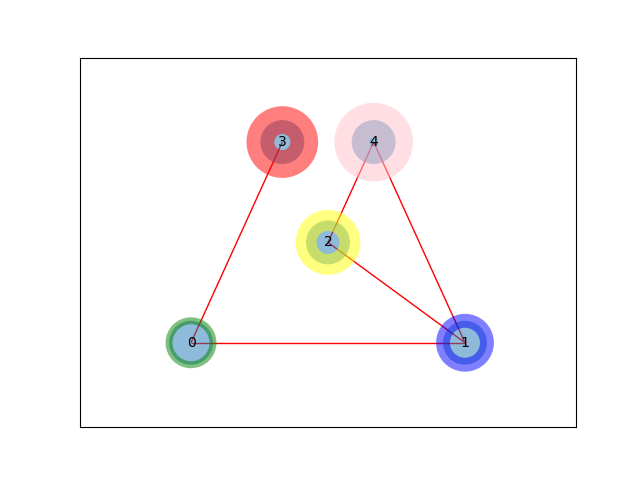

In [312]:
N.draw_railway_network()

In [243]:
N.trial()

**************************************************
Station 1
Station name : alpha
Number of tracks : 5
Number of free tracks : 4
Track status
Track 0 : not free
Track 1 : free
Track 2 : free
Track 3 : free
Track 4 : free
**************************************************
**************************************************
Station 2
Station name : beta
Number of tracks : 3
Number of free tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
**************************************************
Station 3
Station name : gamma
Number of tracks : 2
Number of free tracks : 2
Track status
Track 0 : free
Track 1 : free
**************************************************
**************************************************
Station 4
Station name : delta
Number of tracks : 3
Number of free tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
******************************

<IPython.core.display.Javascript object>


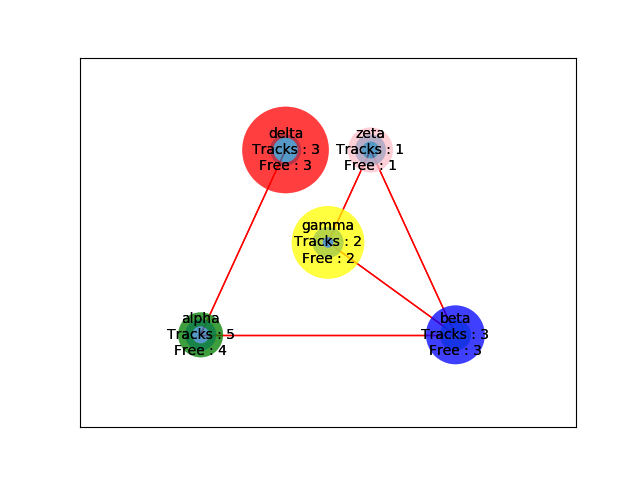

In [244]:
N.draw_railway_network()

In [89]:
stations_dict = read_stations("stations.txt")

In [90]:
for name,s in stations_dict.items():
    s.print_details()

**************************************************
Station 6
Station name : alpha
Number of tracks : 5
Track status
Track 0 : free
Track 1 : free
Track 2 : free
Track 3 : free
Track 4 : free
**************************************************
**************************************************
Station 7
Station name : beta
Number of tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
**************************************************
Station 8
Station name : gamma
Number of tracks : 2
Track status
Track 0 : free
Track 1 : free
**************************************************
**************************************************
Station 9
Station name : delta
Number of tracks : 3
Track status
Track 0 : free
Track 1 : free
Track 2 : free
**************************************************
**************************************************
Station 10
Station name : zeta
Number of tracks : 1
Track status
Track 0 : free
*******

In [47]:
s = Station("hi" , 6)
stations_dict['alpha'].print_details()

**************************************************
Station 21
Station name : alpha
Number of tracks : 5
Track status
Track 0 : free
Track 1 : free
Track 2 : free
Track 3 : free
Track 4 : free
**************************************************


In [35]:
t = Track(5 , np.array([1 ,2 ,3 , 4, 5]) )

In [36]:
temp = np.array([1,2,3])

In [37]:
t.print_details()

**************************************************
Tracks ID : 1
Number of tracks : 5
Average lenght : 3.0
Track status
Track 0 : status : free , length : 1
Track 1 : status : free , length : 2
Track 2 : status : free , length : 3
Track 3 : status : free , length : 4
Track 4 : status : free , length : 5
**************************************************
